# 1. read data

In [1]:
import math
import numpy as np
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import yaml
from pprint import pprint
from scipy.interpolate import interp1d

import larch
from larch import Group
from larch.xafs import xftf, xftr

import torch
import lightning.pytorch as pl
from torch import nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset,IterableDataset
from lightning.pytorch.callbacks import LearningRateMonitor

from util.data_preparation.data_mod import *
from util.data_preparation.data_loader import *
from util.data_preparation.data_helper import *
import util.data_preparation.tune_Eo_helper as E0_helper
from util.NN_architecture import *
from util.NN_helper import *
from util.NN_model import *
from scipy.signal import savgol_filter
from util import gr_util
import util.EXAFS_reconstruction_util as exafs_recon


In [2]:
%matplotlib widget

# correct E0

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.003071056519390357
       x: [ 5.590e+00]
     nit: 6
     jac: [-2.300e-06]
    nfev: 92
    njev: 46


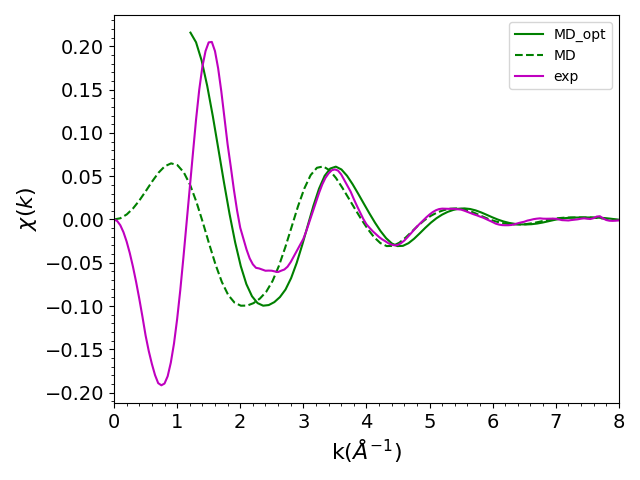

In [3]:
spectrum_MD=pd.read_csv("MD_data/output_ave_test_kx_MD.csv",header=0,sep=',')
k_MD=spectrum_MD['k'].values
chi_MD=spectrum_MD['UF4'].values
chi_exp=np.loadtxt('exp/merge_UF4_HT_abs_17169.9_rbkg1.3_12312023.chik')[:,1]
k_exp=np.loadtxt('exp/merge_UF4_HT_abs_17169.9_rbkg1.3_12312023.chik')[:,0]

exp_cut,kwin_exp=kdata_cut_win(k_exp,chi_exp,bound=[1,8.5],window='hanning')
MD_cut,kwin=kdata_cut_win(np.array(k_MD),np.array(chi_MD),bound=[1,8.5],window='hanning')

opt=E0_helper.optimize(k_MD,MD_cut,k_exp,exp_cut,kweight=0)
deltaE=opt.x[0]
print(opt)

kmesh_recon,chi_MD_recon=E0_helper.reconstruction(k_MD,chi_MD,deltaE)
fig,ax=plt.subplots()
ax.plot(kmesh_recon,kmesh_recon**0*chi_MD_recon,'-',color='green',label='MD_opt')
# ax.plot(kmesh_recon,chi_MD_recon,'-',color='green',label='MD_recon')
ax.plot(k_MD,k_MD**0*MD_cut,'--',color='green',label='MD')
# ax.plot(k_MD,MD_cut,'--',color='green',label='MD')
ax.plot(k_exp,k_exp**0*exp_cut*1.3,'-',color='m',label='exp')
# ax.plot(k_exp,exp_cut,'-',color='m',label='exp')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlabel('k($\AA^{-1}$)',fontsize=16)
ax.set_ylabel('$\chi(k)$',fontsize=16)
ax.tick_params(labelsize=14)
ax.tick_params(labelsize=14)
ax.set_xlim([0,8])

plt.legend()
plt.tight_layout()

# data import

In [4]:
# spectrum=pd.read_csv("dataset11112023/output_ave_test_kx.csv",header=0)
# gr=pd.read_csv("dataset11112023/gr.csv",index_col=0)
# gr_U=pd.read_csv("dataset11112023/gr_U.csv",index_col=0)
# gr_F=pd.read_csv("dataset11112023/gr_F.csv",index_col=0)
spectrum=pd.read_csv("dataset_partial/output_ave_test_kx.csv",header=0,sep=',')
spectrum=auto_tuneE0(spectrum,opt.x[0])
spectrum.to_csv("dataset_partial/output_rebin.csv",index=False)
np.savetxt('dataset_partial/kmesh_rebin.txt',spectrum['k'].values)
gr=pd.read_csv("dataset_partial/gr.csv",index_col=0)
gr_MD=pd.read_csv("MD_data/gr_UF4_0904.csv",index_col=0)
kmesh=np.array(spectrum['k'])
# np.savetxt('kmesh.txt',kmesh)
# rmesh=np.loadtxt('dataset11112023/rmesh.txt')
rmesh=np.loadtxt('dataset_partial/rmesh.txt')

spectrum,gr=drop_bad_data(spectrum,[gr])
# gr_train,r=data_concate(gr,rmesh)
# kmesh=np.loadtxt('dataset11112023/kmesh.txt')

spectrum

number of bad data:362


,k,config_1,config_2,config_3,config_4,config_8,config_10,config_11,config_12,config_14,...,config_986,config_987,config_988,config_989,config_991,config_992,config_993,config_994,config_996,config_997
0,1.211294,0.117428,0.180397,0.119193,0.047926,0.107817,0.287240,0.081412,0.112977,0.110527,...,0.003175,0.205457,0.160155,0.178638,0.052423,0.261497,0.067397,0.263101,0.128681,0.130650
1,1.305894,0.132671,0.210180,0.143438,0.069368,0.108056,0.285011,0.094912,0.128158,0.104233,...,0.031475,0.220697,0.168559,0.181210,0.040906,0.288031,0.087429,0.291052,0.136593,0.128274
2,1.400494,0.143459,0.221489,0.155996,0.090242,0.104967,0.265882,0.106280,0.138022,0.090896,...,0.058723,0.228452,0.171181,0.178340,0.026171,0.286540,0.105989,0.308853,0.136189,0.115155
3,1.495094,0.148313,0.211213,0.152345,0.108275,0.098031,0.229640,0.114199,0.140613,0.070996,...,0.082513,0.226758,0.166880,0.169299,0.009640,0.254275,0.121452,0.313244,0.127005,0.091833
4,1.589693,0.147065,0.183064,0.133557,0.121790,0.087535,0.180405,0.117985,0.135829,0.046774,...,0.101532,0.215690,0.156030,0.154777,-0.006823,0.197998,0.132675,0.303745,0.110909,0.061893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,19.658248,0.000178,0.000038,-0.000056,-0.000151,-0.000174,-0.000369,-0.000206,0.000218,0.000255,...,-0.000135,-0.000058,0.000078,0.000065,-0.000155,0.000011,-0.000193,0.000158,0.000097,0.000186
196,19.752848,0.000133,-0.000040,-0.000006,0.000125,-0.000384,-0.000173,-0.000029,0.000313,0.000103,...,-0.000165,-0.000185,0.000193,-0.000256,-0.000083,0.000014,0.000034,0.000176,-0.000019,0.000002
197,19.847448,-0.000007,-0.000104,0.000060,0.000328,-0.000425,0.000080,0.000125,0.000205,-0.000110,...,-0.000112,-0.000228,0.000183,-0.000483,0.000012,0.000013,0.000204,0.000105,-0.000121,-0.000175
198,19.942048,-0.000146,-0.000113,0.000111,0.000391,-0.000265,0.000263,0.000168,-0.000051,-0.000256,...,-0.000012,-0.000162,0.000065,-0.000485,0.000081,-0.000007,0.000228,-0.000018,-0.000159,-0.000253


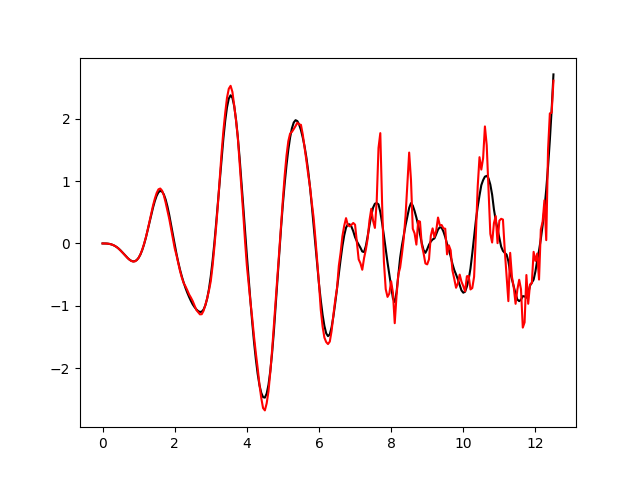

In [5]:
a=np.array([[0,0,0],[1,1,1],[2,2,2]])
np.mean(a,axis=0)
exp_data=np.loadtxt('exp/merge_UF4_HT_abs_17169.9_rbkg1.3_12312023.chik')
filter_chi=savgol_filter(exp_data[:,1],19,3)
plt.figure()
plt.plot(exp_data[:,0],exp_data[:,0]**3*filter_chi*1.3,'k',label='exp')
plt.plot(exp_data[:,0],exp_data[:,0]**3*exp_data[:,1]*1.3,'r',label='exp')

200


203

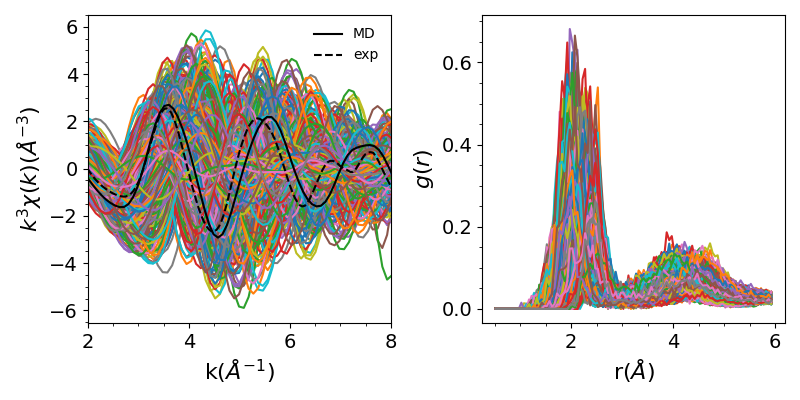

In [6]:
fig,ax=plt.subplots(1,2,figsize=(8,4))
keys=list(spectrum.keys())[1:]
k=spectrum['k']
for i in range(len(keys)):
    # print(i)
    ax[0].plot(k,k**3*spectrum[keys[i]],'-')

    ax[1].plot(rmesh,gr[0][keys[i]],'-')

    # for j in range(1,len(rmesh)):
    #     print(j)
    #     ax[2].plot(rmesh[j-1]+(rmesh[j]-rmesh[j-1])/2,(gr_MD.iloc[i][j]-gr_MD.iloc[i][j-1])/(rmesh[j]-rmesh[j-1]),'.')
# ax[0].plot(k[:-150],spectrum[keys[100]][:-150],'k-',label='MD')
ax[0].plot(kmesh_recon,kmesh_recon**3*chi_MD_recon,'k-',label='MD')
ax[0].plot(exp_data[:,0],exp_data[:,0]**3*filter_chi*1.4,'k--',label='exp')
ax[0].legend(frameon=False)
# ax[1].plot(rmesh,gr.iloc[100])
ax[0].set_xlabel('k($\AA^{-1}$)',fontsize=16)
ax[0].set_ylabel('$k^3\chi(k)$($\AA^{-3}$)',fontsize=16)
ax[0].set_xlim(2,8)
ax[1].set_xlabel('r($\AA$)',fontsize=16)
ax[1].set_ylabel('$g(r)$',fontsize=16)
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[1].yaxis.set_minor_locator(ticker.AutoMinorLocator())
# ax[1].set_xlim(1,6)
plt.tight_layout()
fig.savefig('EXAFS-gr(fig1).png',dpi=300)
print(len(k))
gr_max=[]
for i in range(len(keys)):
    gr_max.append(max(gr[0][keys[i]]))
gr_max=np.array(gr_max)
len(gr_max[gr_max>0.35])

In [7]:
#setup parameters
with open('config/config_11162023.yaml','r') as file:
    NN_config=yaml.safe_load(file)

parameters = {
    'batch_size':128, #64
    'output1':NN_config['output1']['value'],
    'kernel1':NN_config['kernel1']['value'],
    'dropout1':NN_config['dropout1']['value'],
    'output2':NN_config['output2']['value'],
    'kernel2':NN_config['kernel2']['value'],
    'dropout2':NN_config['dropout2']['value'],
    'output3':NN_config['output3']['value'],
    'kernel3':NN_config['kernel3']['value'],
    'dropout3':NN_config['dropout3']['value'],
     'lr':1e-2,
     'linear1':NN_config['l_nn']['value'],
     'training_noise_level':0.1,
     'kmesh_points':NN_config['kmesh_points']['value'],
    'rmesh_points':200,#150
    'concate':False,
    'partial_gr':False
}
pprint(parameters)
data_mod=NNGrDataModule(data_dir='dataset_partial/',
               spectra_data_path='output_rebin.csv',
               gr_data_path=['gr.csv'],
               kmesh_path='kmesh_rebin.txt',
               rmesh_path='rmesh.txt',
               kmesh_bound=[1.5,8.5],
               rmesh_bound=[1.5,5.5],
               k_win_range=[2,8],
               kmesh_points=parameters['kmesh_points'],
               rmesh_points=parameters['rmesh_points'],
               training_noise_level=parameters['training_noise_level'],
               batch=parameters['batch_size'],
               dx=2,
               deltaE=deltaE,
               window_func="hanning",
               kweight=3,
               concate=parameters['concate'],
               partial_gr=parameters['partial_gr'],
               )
data_mod.prepare_data_train()
data_mod.setup(stage='fit')
train_loader=data_mod.train_dataloader()
val_loader=data_mod.val_dataloader()
# rlength=len(data_mod.r_dict['r_F'])+len(data_mod.r_dict['r_U'])
#128

{'batch_size': 128,
 'concate': False,
 'dropout1': 0.14422237216667763,
 'dropout2': 0.20800596660942364,
 'dropout3': 0.06323272370470817,
 'kernel1': 11,
 'kernel2': 11,
 'kernel3': 7,
 'kmesh_points': 150,
 'linear1': 250,
 'lr': 0.01,
 'output1': 64,
 'output2': 32,
 'output3': 16,
 'partial_gr': False,
 'rmesh_points': 200,
 'training_noise_level': 0.1}
number of bad data:362


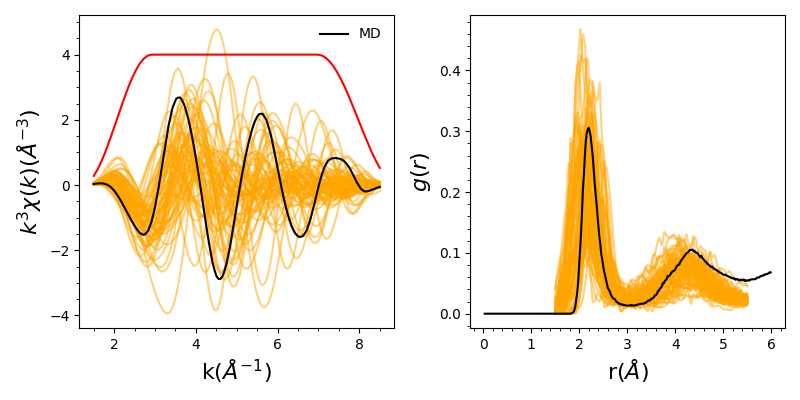

In [8]:
spectrum_MD=pd.read_csv("MD_data/output_ave_test_kx_MD.csv")
keys=list(spectrum_MD.keys())[1:]
# gr_MD=np.loadtxt('MD_data/gr_UF4.txt')
# # gr_MD_F=np.loadtxt('MD_data/gr_UF4_F.txt')
# # gr_MD_U=np.loadtxt('MD_data/gr_UF4_U.txt')
# kmesh_MD=np.array(spectrum_MD['k'])
# rmesh_MD=np.loadtxt('MD_data/r_UF4.txt')
gr_MD_table=pd.read_csv("MD_data/gr_output.csv")
gr_MD=gr_MD_table["UF4"]
kmesh_MD=np.array(spectrum_MD['k'])
rmesh_MD=np.array(gr_MD_table['r'])


train_features, train_labels = next(iter(train_loader))
val_features, val_labels = next(iter(val_loader))
if data_mod.window_func=='hanning':
    spectrum_test,w=data_mod.prepare_predict_data(chi_MD_recon,kmesh_recon)
else:
    spectrum_test=data_mod.prepare_predict_data(chi_MD_recon,kmesh_recon)

fig,ax=plt.subplots(1,2,figsize=(8,4))
kmesh_new=data_mod.kmesh_new
if data_mod.window_func=='hanning':
    win=data_mod.w
# rmesh_new=data_mod.rmesh_new
for i in range(64):
    ax[0].plot(kmesh_new,val_features[i][0],color='orange',alpha=0.5)
if data_mod.window_func=='hanning':
    ax[0].plot(kmesh_new,win*4,'r')
ax[0].plot(kmesh_new,spectrum_test[0][0],'k-',label='MD')
ax[0].set_xlabel('k($\AA^{-1}$)',fontsize=16)
ax[0].set_ylabel('$k^3\chi(k)$($\AA^{-3}$)',fontsize=16)

ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].legend(frameon=False)
for i in range(64):
    ax[1].plot(data_mod.rmesh_new,train_labels[i],color='orange',alpha=0.5)
ax[1].plot(rmesh_MD,gr_MD,'k-')
ax[1].set_xlabel('r($\AA$)',fontsize=16)
ax[1].set_ylabel('$g(r)$',fontsize=16)
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[1].yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.tight_layout()
plt.savefig('EXAFS-gr(fig1.5).png',dpi=300)


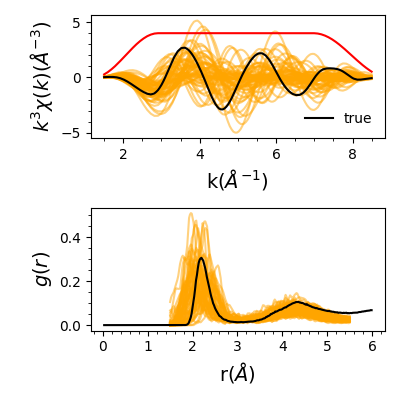

In [9]:
spectrum_MD=pd.read_csv("MD_data/output_ave_test_kx_MD.csv")
keys=list(spectrum_MD.keys())[1:]
# gr_MD=np.loadtxt('MD_data/gr_UF4.txt')
# # gr_MD_F=np.loadtxt('MD_data/gr_UF4_F.txt')
# # gr_MD_U=np.loadtxt('MD_data/gr_UF4_U.txt')
# kmesh_MD=np.array(spectrum_MD['k'])
# rmesh_MD=np.loadtxt('MD_data/r_UF4.txt')
gr_MD_table=pd.read_csv("MD_data/gr_output.csv")
gr_MD=gr_MD_table["UF4"]
kmesh_MD=np.array(spectrum_MD['k'])
rmesh_MD=np.array(gr_MD_table['r'])


train_features, train_labels = next(iter(train_loader))
val_features, val_labels = next(iter(val_loader))
if data_mod.window_func=='hanning':
    spectrum_test,w=data_mod.prepare_predict_data(chi_MD_recon,kmesh_recon)
else:
    spectrum_test=data_mod.prepare_predict_data(chi_MD_recon,kmesh_recon)

fig,ax=plt.subplots(2,1,figsize=(4,4))
kmesh_new=data_mod.kmesh_new
if data_mod.window_func=='hanning':
    win=data_mod.w
# rmesh_new=data_mod.rmesh_new
for i in range(64):
    ax[0].plot(kmesh_new,val_features[i][0],color='orange',alpha=0.5)
if data_mod.window_func=='hanning':
    ax[0].plot(kmesh_new,win*4,'r')
ax[0].plot(kmesh_new,spectrum_test[0][0],'k-',label='true')
ax[0].set_xlabel('k($\AA^{-1}$)',fontsize=14)
ax[0].set_ylabel('$k^3\chi(k)$($\AA^{-3}$)',fontsize=14)

ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].legend(frameon=False)
for i in range(64):
    ax[1].plot(data_mod.rmesh_new,train_labels[i],color='orange',alpha=0.5)
ax[1].plot(rmesh_MD,gr_MD,'k-')
ax[1].set_xlabel('r($\AA$)',fontsize=14)
ax[1].set_ylabel('$g(r)$',fontsize=14)
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[1].yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.tight_layout()
# plt.savefig('EXAFS-gr(fig1.5).png',dpi=300)

# Training Neural network

In [12]:
%reload_ext tensorboard 
%tensorboard --logdir=cbam/rebinE0 --port 5808

Launching TensorBoard...

In [13]:
#solar-sweep-102

In [10]:
data_mod.prepare_data_train()

kmesh_new=data_mod.kmesh_new
batch_size=data_mod.batch
data_mod.setup(stage='fit')
train_loader=data_mod.train_dataloader()
val_loader=data_mod.val_dataloader()

number of bad data:362


In [174]:
for i in range(10):
    net=GEXNN_AT_para(feature_len=len(kmesh_new),gr_len=data_mod.rmesh_points,config_para=parameters)
    model=NN_model(net,loss_func=nn.L1Loss(),lr=parameters['lr'])
    steps_per_epoch = int(20000/batch_size) #change from 40000
    #trainer = pl.Trainer(max_epochs=1000, limit_train_batches=steps_per_epoch,limit_val_batches=steps_per_epoch,callbacks=[pl.callbacks.EarlyStopping(monitor='val_loss', patience=8, min_delta=0.01, mode='min',verbose=False)])
    lr_monitor = LearningRateMonitor(logging_interval='epoch')#FineTuneLearningRateFinder(attr_name='lr',update_attr=True),
    # trainer = pl.Trainer(default_root_dir="cbam/no_f1219", max_epochs=400,gradient_clip_val=3,limit_train_batches=steps_per_epoch,limit_val_batches=steps_per_epoch,callbacks=[lr_monitor])
    # trainer = pl.Trainer(default_root_dir="cbam/no_f1222_k3", max_epochs=500,gradient_clip_val=5,limit_train_batches=steps_per_epoch,limit_val_batches=steps_per_epoch,callbacks=[lr_monitor])
    trainer = pl.Trainer(default_root_dir="cbam/rebinE0", max_epochs=500,gradient_clip_val=0.05,limit_train_batches=steps_per_epoch,limit_val_batches=steps_per_epoch,callbacks=[lr_monitor,pl.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0001, mode='min',verbose=False)])
    trainer.fit(model, train_loader, val_loader)

INFO: GPU available: True (cuda), used: True
INFO [2024-01-02 13:48:33]: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO [2024-01-02 13:48:33]: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO [2024-01-02 13:48:33]: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO [2024-01-02 13:48:33]: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO [2024-01-02 13:48:33]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | net           | GEXNN_AT_para | 678 K 
1 | loss          | L1Loss        | 0     
2 | train_loss    | MeanMetric    | 0     
3 | val_loss      | MeanMetric    | 0     
4 | val_loss_best | MinMetric     | 0     
------------------------------------------------
678 K     Trainable params
0         Non-trainable params
678 K     Total param

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO [2024-01-02 14:07:13]: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO [2024-01-02 14:07:13]: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO [2024-01-02 14:07:13]: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO [2024-01-02 14:07:14]: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO [2024-01-02 14:07:14]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | net           | GEXNN_AT_para | 678 K 
1 | loss          | L1Loss        | 0     
2 | train_loss    | MeanMetric    | 0     
3 | val_loss      | MeanMetric    | 0     
4 | val_loss_best | MinMetric     | 0     
------------------------------------------------
678 K     Trainable params
0         Non-trainable params
678 K     Total param

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO [2024-01-02 14:30:01]: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO [2024-01-02 14:30:01]: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO [2024-01-02 14:30:01]: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO [2024-01-02 14:30:01]: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO [2024-01-02 14:30:01]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | net           | GEXNN_AT_para | 678 K 
1 | loss          | L1Loss        | 0     
2 | train_loss    | MeanMetric    | 0     
3 | val_loss      | MeanMetric    | 0     
4 | val_loss_best | MinMetric     | 0     
------------------------------------------------
678 K     Trainable params
0         Non-trainable params
678 K     Total param

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO [2024-01-02 14:48:24]: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO [2024-01-02 14:48:24]: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO [2024-01-02 14:48:24]: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO [2024-01-02 14:48:24]: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO [2024-01-02 14:48:24]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | net           | GEXNN_AT_para | 678 K 
1 | loss          | L1Loss        | 0     
2 | train_loss    | MeanMetric    | 0     
3 | val_loss      | MeanMetric    | 0     
4 | val_loss_best | MinMetric     | 0     
------------------------------------------------
678 K     Trainable params
0         Non-trainable params
678 K     Total param

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO [2024-01-02 15:00:03]: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO [2024-01-02 15:00:03]: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO [2024-01-02 15:00:03]: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO [2024-01-02 15:00:03]: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO [2024-01-02 15:00:03]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | net           | GEXNN_AT_para | 678 K 
1 | loss          | L1Loss        | 0     
2 | train_loss    | MeanMetric    | 0     
3 | val_loss      | MeanMetric    | 0     
4 | val_loss_best | MinMetric     | 0     
------------------------------------------------
678 K     Trainable params
0         Non-trainable params
678 K     Total param

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO [2024-01-02 15:06:51]: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO [2024-01-02 15:06:51]: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO [2024-01-02 15:06:51]: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO [2024-01-02 15:06:51]: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO [2024-01-02 15:06:51]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | net           | GEXNN_AT_para | 678 K 
1 | loss          | L1Loss        | 0     
2 | train_loss    | MeanMetric    | 0     
3 | val_loss      | MeanMetric    | 0     
4 | val_loss_best | MinMetric     | 0     
------------------------------------------------
678 K     Trainable params
0         Non-trainable params
678 K     Total param

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO [2024-01-02 15:11:58]: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO [2024-01-02 15:11:58]: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO [2024-01-02 15:11:58]: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO [2024-01-02 15:11:58]: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO [2024-01-02 15:11:58]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | net           | GEXNN_AT_para | 678 K 
1 | loss          | L1Loss        | 0     
2 | train_loss    | MeanMetric    | 0     
3 | val_loss      | MeanMetric    | 0     
4 | val_loss_best | MinMetric     | 0     
------------------------------------------------
678 K     Trainable params
0         Non-trainable params
678 K     Total param

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO [2024-01-02 15:21:07]: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO [2024-01-02 15:21:07]: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO [2024-01-02 15:21:07]: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO [2024-01-02 15:21:07]: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO [2024-01-02 15:21:07]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | net           | GEXNN_AT_para | 678 K 
1 | loss          | L1Loss        | 0     
2 | train_loss    | MeanMetric    | 0     
3 | val_loss      | MeanMetric    | 0     
4 | val_loss_best | MinMetric     | 0     
------------------------------------------------
678 K     Trainable params
0         Non-trainable params
678 K     Total param

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO [2024-01-02 15:29:17]: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO [2024-01-02 15:29:17]: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO [2024-01-02 15:29:17]: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO [2024-01-02 15:29:17]: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO [2024-01-02 15:29:17]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | net           | GEXNN_AT_para | 678 K 
1 | loss          | L1Loss        | 0     
2 | train_loss    | MeanMetric    | 0     
3 | val_loss      | MeanMetric    | 0     
4 | val_loss_best | MinMetric     | 0     
------------------------------------------------
678 K     Trainable params
0         Non-trainable params
678 K     Total param

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: GPU available: True (cuda), used: True
INFO [2024-01-02 15:38:20]: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO [2024-01-02 15:38:20]: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO [2024-01-02 15:38:20]: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO [2024-01-02 15:38:20]: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO [2024-01-02 15:38:20]: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type          | Params
------------------------------------------------
0 | net           | GEXNN_AT_para | 678 K 
1 | loss          | L1Loss        | 0     
2 | train_loss    | MeanMetric    | 0     
3 | val_loss      | MeanMetric    | 0     
4 | val_loss_best | MinMetric     | 0     
------------------------------------------------
678 K     Trainable params
0         Non-trainable params
678 K     Total param

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [15]:
from glob import glob
from util.NN_helper import *
foldernames=glob("cbam/rebinE0/lightning_logs/*")
model_list=[]
kmesh_new=data_mod.kmesh_new
rmesh_new=data_mod.ori_rmesh
batch_size=data_mod.batch
data_mod.setup(stage='fit')
train_loader=data_mod.train_dataloader()
val_loader=data_mod.val_dataloader()

for i in range(len(foldernames)):
    net=GEXNN_AT_para(feature_len=len(kmesh_new),gr_len=data_mod.rmesh_points,config_para=parameters)
    model=NN_model(net,loss_func=nn.L1Loss(),lr=parameters['lr'])
    filename=glob(foldernames[i]+"/checkpoints/*.ckpt")[0]
    print(filename)
    load_from_checkpoint(model,filename)
    model.to('cpu')
    model.eval()
    model_list.append(model)
# model=[]

cbam/rebinE0/lightning_logs\version_0/checkpoints\epoch=82-step=12948.ckpt
cbam/rebinE0/lightning_logs\version_1/checkpoints\epoch=82-step=12948.ckpt
cbam/rebinE0/lightning_logs\version_2/checkpoints\epoch=66-step=10452.ckpt
cbam/rebinE0/lightning_logs\version_3/checkpoints\epoch=105-step=16536.ckpt
cbam/rebinE0/lightning_logs\version_4/checkpoints\epoch=80-step=12636.ckpt
cbam/rebinE0/lightning_logs\version_5/checkpoints\epoch=60-step=9516.ckpt
cbam/rebinE0/lightning_logs\version_6/checkpoints\epoch=108-step=17004.ckpt
cbam/rebinE0/lightning_logs\version_7/checkpoints\epoch=96-step=15132.ckpt
cbam/rebinE0/lightning_logs\version_8/checkpoints\epoch=107-step=16848.ckpt
cbam/rebinE0/lightning_logs\version_9/checkpoints\epoch=90-step=14196.ckpt


In [16]:
model_list[0]

NN_model(
  (net): GEXNN_AT_para(
    (CNNAT): Sequential(
      (0): AT_CNN_block(
        (CNNB): Sequential(
          (0): Conv1d(1, 64, kernel_size=(11,), stride=(1,), padding=(5,))
          (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): CBAM(
            (ChannelGate): ChannelGate(
              (mlp): Sequential(
                (0): Flatten()
                (1): Linear(in_features=64, out_features=4, bias=True)
                (2): ReLU()
                (3): Linear(in_features=4, out_features=64, bias=True)
              )
            )
            (SpatialGate): SpatialGate(
              (compress): ChannelPool()
              (spatial): BasicConv(
                (conv): Conv1d(2, 1, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
                (bn): BatchNorm1d(1, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
              )
            )
          )
          (4): Dr

# test

In [17]:
y_predict_list=[]
test_x,test_y=data_mod.prepare_test_data()
for i in range(len(model_list)):
    y_predict=model_list[i](test_x)
    y_predict_list.append(y_predict.detach().numpy())

t_set=test_y.detach().numpy()
max_index=np.where(np.max(t_set,axis=1)>0.33)[0]
len(max_index)

29

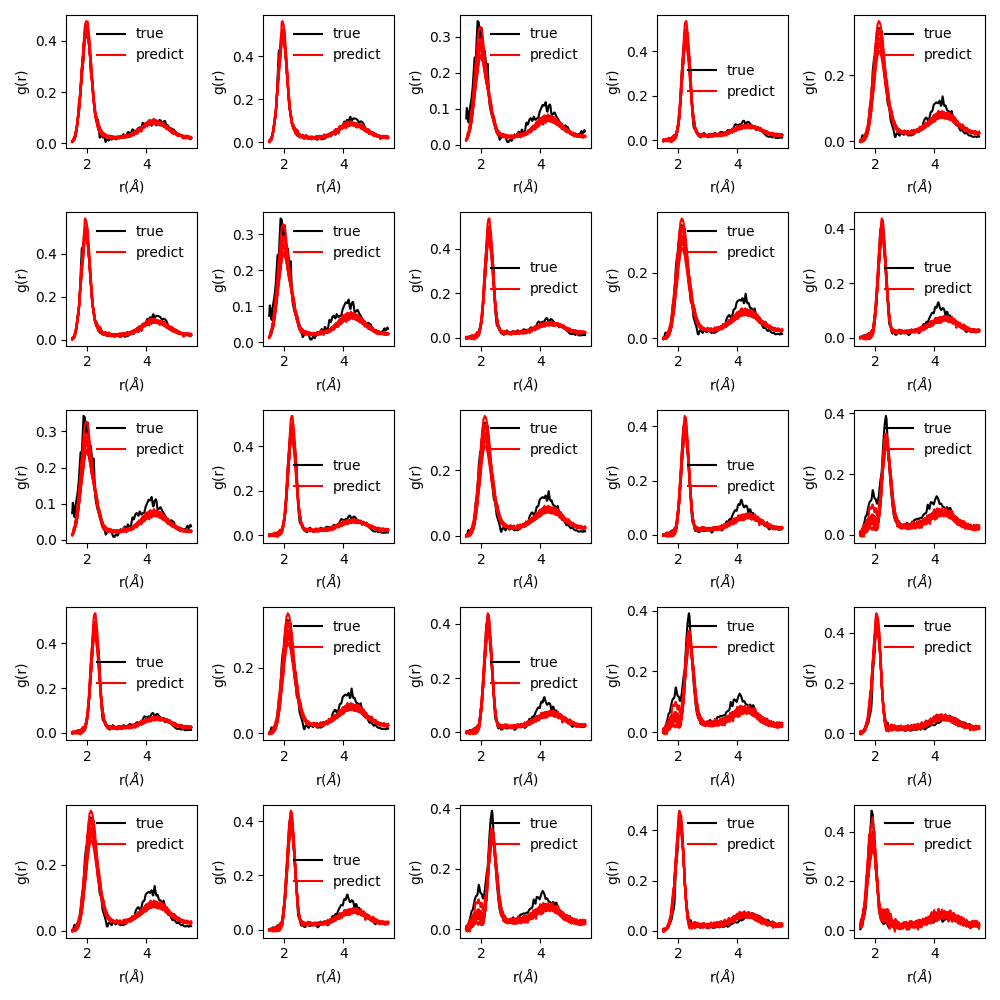

In [18]:

fig,ax=plt.subplots(5,5,figsize=(10,10))
kk=0
for i in range(5):
  for j in range(5):
    # ax[i,j].plot(test_y[i+j+10],'k',label='true')
    # ax[i,j].plot(y_predict[i+j+10],'r',label='predict')
    ax[i,j].plot(data_mod.rmesh_new,test_y[max_index[i+j]],'k',label='true')
    for k in range(len(model_list)):
      if k==0:
        ax[i,j].plot(data_mod.rmesh_new,y_predict_list[k][max_index[i+j]],'r',label='predict')
      else:
        ax[i,j].plot(data_mod.rmesh_new,y_predict_list[k][max_index[i+j]],'r')
      ax[i,j].legend(frameon=False)
    ax[i,j].set_xlabel('r($\AA$)')
    ax[i,j].set_ylabel('g(r)')
    kk+=1
    

plt.tight_layout()

# predict

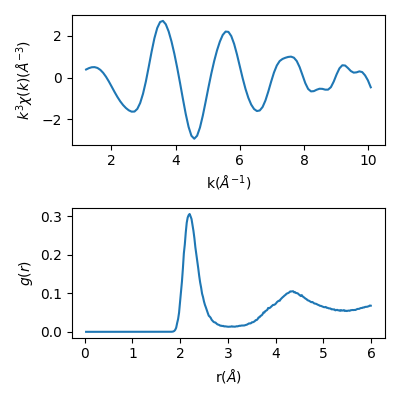

In [19]:
# gr_MD=np.loadtxt('MD_data/gr_UF4.txt')
# # gr_MD_F=np.loadtxt('MD_data/gr_UF4_F.txt')
# # gr_MD_U=np.loadtxt('MD_data/gr_UF4_U.txt')
# kmesh_MD=np.array(spectrum_MD['k'])
# rmesh_MD=np.loadtxt('MD_data/r_UF4.txt')
gr_MD_table=pd.read_csv("MD_data/gr_output.csv")
gr_MD=gr_MD_table["UF4"]
kmesh_MD=np.array(spectrum_MD['k'])
rmesh_MD=np.array(gr_MD_table['r'])
chi_MD_recon
rmesh_new_MD=rmesh_MD
kmesh_new_MD=data_mod.kmesh_new

fig,ax=plt.subplots(2,1,figsize=(4,4))

# for i in range(len(keys)):
ax[0].plot(kmesh_recon,kmesh_recon**3*chi_MD_recon)
# ax[0].plot(kmesh_MD,kmesh_MD**3*chi_MD,'k--')
ax[1].plot(rmesh_MD,gr_MD)
# ax[1].plot(rmesh_MD,gr_MD_F)
# ax[1].plot(rmesh_MD,gr_MD_U)
ax[0].set_xlabel('k($\AA^{-1}$)')
ax[0].set_ylabel('$k^3\chi(k)$($\AA^{-3}$)')
ax[1].set_xlabel('r($\AA$)')
ax[1].set_ylabel('$g(r)$')
plt.tight_layout()


In [20]:
gr_MD

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
293    0.064982
294    0.065881
295    0.066517
296    0.068292
297    0.067854
Name: UF4, Length: 298, dtype: float64

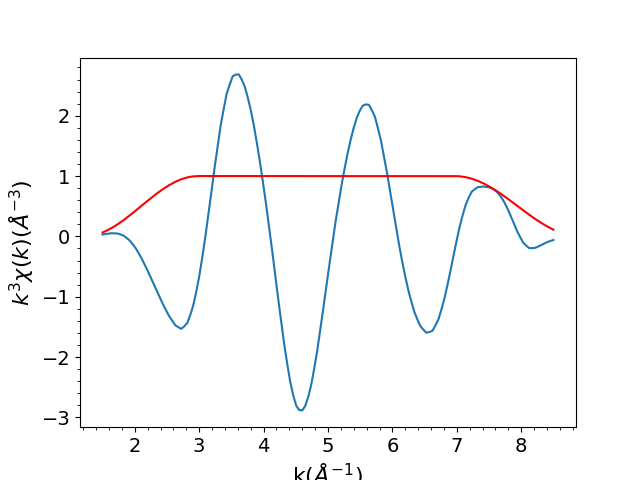

In [21]:
# kmesh_new=data_mod.kmesh_new
if data_mod.window_func=='hanning':
    spectrum_test,w=data_mod.prepare_predict_data(chi_MD_recon,kmesh_recon)
else:
    spectrum_test=data_mod.prepare_predict_data(chi_MD_recon,kmesh_recon)

fig,ax=plt.subplots()
plt.plot(kmesh_new_MD,spectrum_test[0][0])
plt.plot(kmesh_new_MD,w,'r')
ax.set_xlabel('k($\AA^{-1}$)',fontsize=16)
ax.set_ylabel('$k^3\chi(k)$($\AA^{-3}$)',fontsize=16)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(labelsize=14)
# spectrum_test[0][0][0]

CN_MD=7.88207215092969
CN_predict_max=9.054055493514337
CN_predict_min=7.515291322600187
CN_predict=8.16+/-0.8


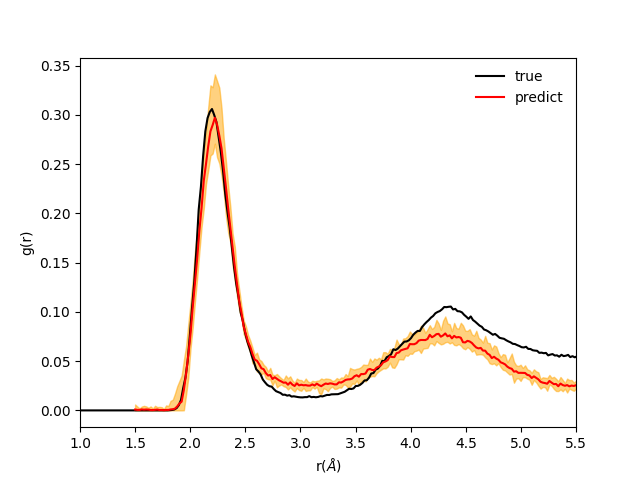

In [22]:

fig,ax=plt.subplots()

y_predict_list=[]
for i in range(len(model_list)):
    y_predict=model_list[i](spectrum_test)
    # y_predict=y_predict.detach().numpy() 
    if data_mod.concate==True:
        gr_F,gr_U,gr_total,rmesh_total=data_mod.post_prediction(y_predict[0])
    else:
        gr,rmesh_new_MD=data_mod.post_prediction(y_predict[0])
    # print(f"CN_predict={gr_util.coord_num(gr,rmesh_new,1.8,3)}")
    y_predict_list.append(gr)
    # if i==0:
    #     ax.plot(rmesh_new,np.abs(gr),'r',label='predict')
    # else:
    #     ax.plot(rmesh_new,np.abs(gr),'r')
y_predict_list_MD=np.array(y_predict_list)
CN_predict_MD_list=[]
radius_predict_MD_list=[]
DW_predict_MD_list=[]

y_predict_list_max_MD=np.max(y_predict_list_MD,axis=0)
y_predict_list_min_MD=np.min(y_predict_list_MD,axis=0)
y_predict_list_mean_MD=np.mean(y_predict_list_MD,axis=0)

for i in range(len(y_predict_list_MD)):
    CN_predict_MD_list.append(gr_util.coord_num(y_predict_list_MD[i],rmesh_new_MD,1.8,3))
    radius_predict_MD_list.append(gr_util.radius(y_predict_list_MD[i],rmesh_new_MD,1.8,3))
    DW_predict_MD_list.append(gr_util.DW_factor(y_predict_list_MD[i],rmesh_new_MD,1.8,3))
CN_predict_MD_list=np.array(CN_predict_MD_list)
radius_predict_MD_list=np.array(radius_predict_MD_list)
DW_predict_MD_list=np.array(DW_predict_MD_list)
    
ax.plot(rmesh_MD,gr_MD,'k',label='true')
ax.fill_between(rmesh_new_MD,y_predict_list_min_MD,y_predict_list_max_MD,color='orange',alpha=0.5)
ax.plot(rmesh_new_MD,y_predict_list_mean_MD,'r',label='predict')
ax.set_xlabel("r($\AA$)")
ax.set_ylabel("g(r)")
ax.set_xlim(1,5.5)
ax.legend(frameon=False)
CN_MD=gr_util.coord_num(gr_MD,rmesh_MD,1.8,3)
CN_predict_MD=np.mean(CN_predict_MD_list,axis=0)
CN_predict_max_MD=np.max(CN_predict_MD_list,axis=0)
CN_predict_min_MD=np.min(CN_predict_MD_list,axis=0)



radius_MD=gr_util.radius(gr_MD,rmesh_MD,1.8,3)
radius_predict_MD=np.mean(radius_predict_MD_list,axis=0)
radius_predict_max_MD=np.max(radius_predict_MD_list,axis=0)
radius_predict_min_MD=np.min(radius_predict_MD_list,axis=0)


DW_MD=gr_util.DW_factor(gr_MD,rmesh_MD,1.8,3)
DW_predict_MD=np.mean(DW_predict_MD_list,axis=0)
DW_predict_max_MD=np.max(DW_predict_MD_list,axis=0)
DW_predict_min_MD=np.min(DW_predict_MD_list,axis=0)



print(f"CN_MD={gr_util.coord_num(gr_MD,rmesh_MD,1.8,3)}")
# print(f"CN_predict={gr_util.coord_num(y_predict_list_mean,rmesh_new,1.8,3)}")
print(f"CN_predict_max={CN_predict_max_MD}")
print(f"CN_predict_min={CN_predict_min_MD}")
print(f"CN_predict={np.round(CN_predict_MD,2)}+/-{np.round((CN_predict_max_MD-CN_predict_min_MD)/2,1)}")


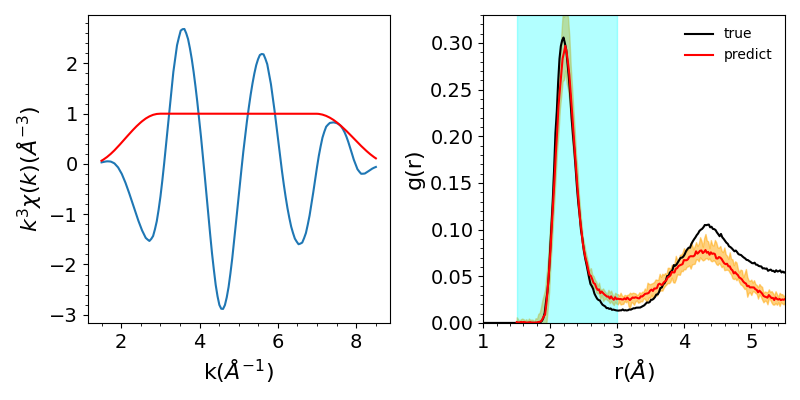

In [23]:
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(kmesh_new_MD,spectrum_test[0][0])
ax[0].plot(kmesh_new_MD,w,'r')
ax[0].set_xlabel('k($\AA^{-1}$)',fontsize=16)
ax[0].set_ylabel('$k^3\chi(k)$($\AA^{-3}$)',fontsize=16)
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].tick_params(labelsize=14)

ax[1].plot(rmesh_MD,gr_MD,'k',label='true')
ax[1].fill_between(rmesh_new_MD,y_predict_list_min_MD,y_predict_list_max_MD,color='orange',alpha=0.5)
ax[1].axvspan(1.5, 3, alpha=0.3, color='cyan')
ax[1].plot(rmesh_new_MD,y_predict_list_mean_MD,'r',label='predict')
# ax[1].text(3,0.2,f"CN={np.round(CN_predict_mean_MD,2)}$\pm${np.round((CN_predict_max_MD-CN_predict_min_MD)/2,1)}",fontsize=14,color='r')
ax[1].set_xlabel("r($\AA$)",fontsize=16)
ax[1].set_ylabel("g(r)",fontsize=16)
ax[1].set_xlim(1,5.5)
ax[1].set_ylim(0,0.33)
ax[1].legend(frameon=False)
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[1].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[1].tick_params(labelsize=14)

fig.tight_layout()
fig.savefig('EXAFS-gr(fig2).png',dpi=300)

In [24]:
ax[1].set_xlabel('r($\AA$)',fontsize=16)
ax[1].set_ylabel('$g(r)$',fontsize=16)
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].tick_params(labelsize=14)
ax[1].tick_params(labelsize=14)
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[1].yaxis.set_minor_locator(ticker.AutoMinorLocator())

In [25]:
# %matplotlib inline

(0.0, 10.0)

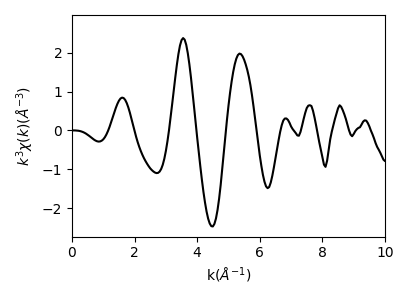

In [26]:

# exp_data=np.loadtxt('exp/merge_UF4_HT_abs17171_2rbkg1.chik')
exp_data=np.loadtxt('exp/merge_UF4_HT_abs_17169.9_rbkg1.3_12312023.chik')
filter_chi=savgol_filter(exp_data[:,1],19,3)
plt.figure(figsize=(4,3))
plt.plot(exp_data[:,0],exp_data[:,0]**3*filter_chi*1.3,'k',label='exp')
plt.xlabel('k($\AA^{-1}$)')
plt.ylabel('$k^3\chi(k)$($\AA^{-3}$)')
plt.tight_layout()
# plt.plot(exp_data[:,0],exp_data[:,0]**3*exp_data[:,1]*1.3,'r',label='exp')
plt.xlim(0,10)

In [27]:
exp_data

array([[ 0.0000000e+00, -8.6868436e-01, -0.0000000e+00, ...,
        -0.0000000e+00,  0.0000000e+00,  1.7169900e+04],
       [ 5.0000000e-02, -8.5208327e-01, -4.2604164e-02, ...,
        -1.0651041e-04,  0.0000000e+00,  1.7169910e+04],
       [ 1.0000000e-01, -8.3548218e-01, -8.3548218e-02, ...,
        -8.3548218e-04,  0.0000000e+00,  1.7169938e+04],
       ...,
       [ 1.2400000e+01,  8.4069789e-04,  1.0424654e-02, ...,
         1.6028948e+00,  0.0000000e+00,  1.7755723e+04],
       [ 1.2450000e+01,  8.3456673e-04,  1.0390356e-02, ...,
         1.6105311e+00,  0.0000000e+00,  1.7760457e+04],
       [ 1.2500000e+01,  1.0273279e-03,  1.2841598e-02, ...,
         2.0064997e+00,  0.0000000e+00,  1.7765210e+04]])

(1.5, 8.5)

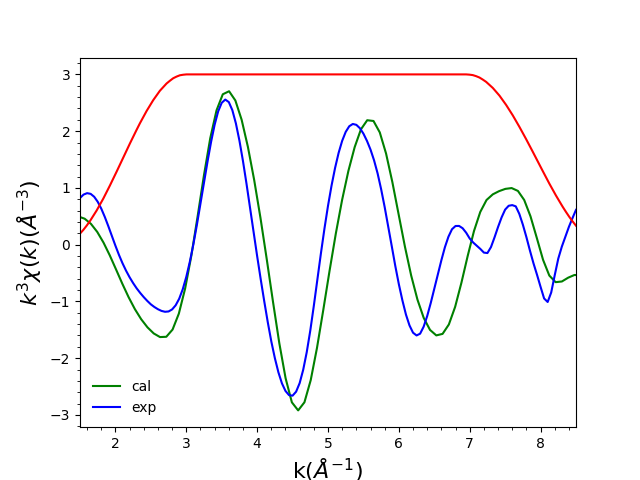

In [28]:

chi=exp_data[:,1]
spectrum_MD=pd.read_csv("MD_data/output_ave_test_kx_MD.csv")
kmesh_MD=np.array(spectrum_MD['k'])
fig,ax=plt.subplots()
ax.plot(kmesh_recon,kmesh_recon**3*chi_MD_recon,'green',label='cal')
ax.plot(exp_data[:,0],exp_data[:,0]**3*filter_chi*1.4,'blue',label='exp')
ax.plot(kmesh_new_MD,w*3,'r')
ax.set_xlabel('k($\AA^{-1}$)',fontsize=16)
ax.set_ylabel('$k^3\chi(k)$($\AA^{-3}$)',fontsize=16)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.legend(frameon=False)

plt.xlim(1.5,8.5)
# plt.plot(exp_data[:,0],exp_data[:,0]**3*filter_chi*1.2,'b',label='cal')
# plt.xlim(2,8)


# k to E and E to k

# predict on experimental data(no back fourier)

In [67]:
# exp_data=np.loadtxt('exp/merge_UF4_HT_abs17171_2rbkg1.chik')
exp_data=np.loadtxt('exp/exp.chik')
chi=filter_chi
factor_exp=1/0.71


k_exp=exp_data[:,0]
kmesh_new_exp=data_mod.kmesh_new
if data_mod.window_func=='hanning':
    spectrum_filter,w=data_mod.prepare_predict_data(chi*factor_exp,k_exp)
else:
    spectrum_filter,w=data_mod.prepare_predict_data(chi*factor_exp,k_exp)



y_predict_filter=model(spectrum_filter)
y_predict_filter=y_predict_filter.detach().numpy() 

Text(0, 0.5, '$k^3\\chi(k)(\\AA^{-3})$')

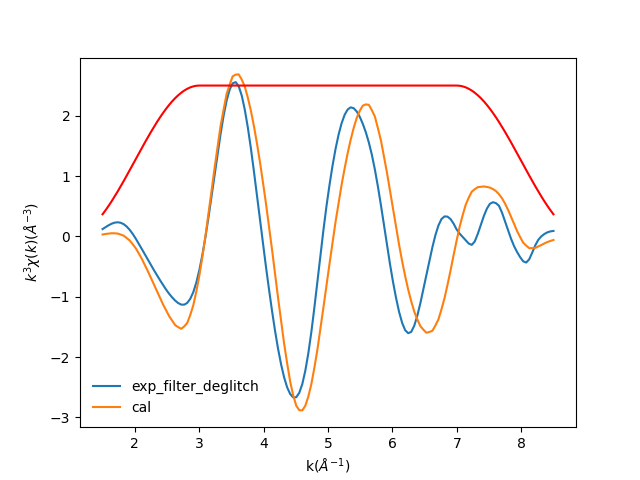

In [68]:
plt.figure()
# plt.plot(kmesh_new,spectrum[0][0],label='exp')
plt.plot(kmesh_new_exp,spectrum_filter[0][0],label='exp_filter_deglitch')
plt.plot(kmesh_new_MD,spectrum_test[0][0],label='cal')
# plt.plot(kmesh_MD,kmesh_MD**3*spectrum_MD['UF4']*0.8,'r',label='cal')
plt.plot(kmesh_new_exp,w*2.5,'r')
# plt.plot(UF4.k,UF4.k*UF4.k*UF4.chi,label='MD')
plt.legend(frameon=False)
plt.xlabel('k($\AA^{-1}$)')
plt.ylabel('$k^3\chi(k)(\AA^{-3})$')

In [31]:
%matplotlib widget

CN_predict=6.749937449194003
CN_predict_max=7.824059928451752
CN_predict_min=5.803411587095547
CN_predict=6.72+/-0.6


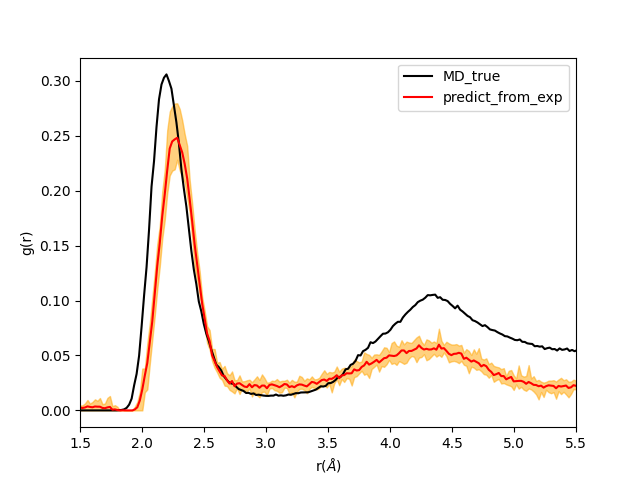

In [32]:
from util.gr_util import DW_factor


fig,ax=plt.subplots()
gr_filter_list=[]
gr_no_list=[]


rmesh_new_exp=data_mod.rmesh_new
for i in range(len(model_list)):
    y_predict_filter=model_list[i](spectrum_filter)
    # y_predict=torch.nn.functional.relu(y_predict)
    # y_predict_filter=torch.nn.functional.relu(y_predict_filter)
    # y_predict_filter=y_predict_filter.detach().numpy() 
    # y_predict=y_predict.detach().numpy()
    if data_mod.concate==True:
        gr_F_filter,gr_U_filter,gr_total_filter,rmesh_total_exp=data_mod.post_prediction(y_predict_filter[0])
    else:
        gr_filter,rmesh_total_exp=data_mod.post_prediction(y_predict_filter[0])
    gr_filter_list.append(gr_filter)
# for i in range(len(gr_no_list)):
#     if i==0:
#         ax.plot(rmesh_total,gr_filter_list[i]*1.2,'r--',label='predict_with_filter')
#         # ax.plot(rmesh_total,gr_no_list[i]*1.2,'r',label='predict_no_filter')
#     else:
#         ax.plot(rmesh_total,gr_filter_list[i]*1.2,'r--')
#         ax.plot(rmesh_total,gr_no_list[i]*1.2,'r')
#     print(f"CN_predict_filter={gr_util.coord_num(gr_filter*1.2,rmesh_total,1.8,2.75)}")


#print(f"CN_predict_no_filter={gr_util.coord_num(gr_no_list[i]*1.2,rmesh_total,1.8,3)}")
y_predict_list_exp=np.array(gr_filter_list)
CN_predict_exp_list=[]
radius_predict_exp_list=[]
DW_predict_exp_list=[]

y_predict_list_max_exp=np.max(y_predict_list_exp,axis=0)
y_predict_list_min_exp=np.min(y_predict_list_exp,axis=0)
y_predict_list_mean_exp=np.mean(y_predict_list_exp,axis=0)

for i in range(len(y_predict_list_exp)):
    CN_predict_exp_list.append(gr_util.coord_num(y_predict_list_exp[i],rmesh_total_exp,1.8,3))
    radius_predict_exp_list.append(gr_util.radius(y_predict_list_exp[i],rmesh_total_exp,1.8,3))
    DW_predict_exp_list.append(gr_util.DW_factor(y_predict_list_exp[i],rmesh_total_exp,1.8,3))
CN_predict_exp_list=np.array(CN_predict_exp_list)
radius_predict_exp_list=np.array(radius_predict_exp_list)
DW_predict_exp_list=np.array(DW_predict_exp_list)
ax.plot(rmesh_MD,gr_MD,'k',label='MD_true')
ax.fill_between(rmesh_new_exp,y_predict_list_min_exp,y_predict_list_max_exp,color='orange',alpha=0.5)

ax.plot(rmesh_new_exp,y_predict_list_mean_exp,'r',label='predict_from_exp')
# ax.plot(rmesh_MD,gr_MD,'k')
plt.legend()
plt.xlim(1.5,5.5)
plt.xlabel("r($\AA$)")
plt.ylabel("g(r)")
# print(f"CN_MD={gr_util.coord_num(gr_MD,rmesh_MD,1.8,3)}")
CN_predict_exp=np.mean(CN_predict_exp_list,axis=0)
CN_predict_max_exp=np.max(CN_predict_exp_list,axis=0)
CN_predict_min_exp=np.min(CN_predict_exp_list,axis=0)


radius_predict_exp=np.mean(radius_predict_exp_list,axis=0)
radius_predict_max_exp=np.max(radius_predict_exp_list,axis=0)
radius_predict_min_exp=np.min(radius_predict_exp_list,axis=0)

DW_predict_exp=np.mean(DW_predict_exp_list,axis=0)
DW_predict_max_exp=np.max(DW_predict_exp_list,axis=0)
DW_predict_min_exp=np.min(DW_predict_exp_list,axis=0)



print(f"CN_predict={gr_util.coord_num(y_predict_list_mean_exp,rmesh_new_exp,1.5,3)}")
print(f"CN_predict_max={gr_util.coord_num(y_predict_list_max_exp,rmesh_new_exp,1.5,3)}")
print(f"CN_predict_min={gr_util.coord_num(y_predict_list_min_exp,rmesh_new_exp,1.5,3)}")
# print(f"CN_predict={gr_util.coord_num(gr_filter*1.2,rmesh_total,1.8,2.75)}")
print(f"CN_predict={np.round(CN_predict_exp,2)}+/-{np.round((CN_predict_max_exp-CN_predict_min_exp)/2,1)}")

In [33]:
radius_predict_min_exp

2.3676912963463295

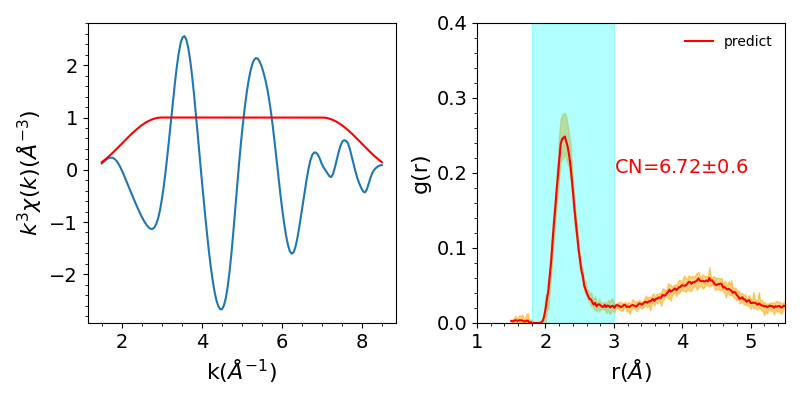

In [34]:
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(kmesh_new_exp,spectrum_filter[0][0],label='exp_filter_deglitch')
ax[0].plot(kmesh_new_exp,w,'r')
ax[0].set_xlabel('k($\AA^{-1}$)',fontsize=16)
ax[0].set_ylabel('$k^3\chi(k)$($\AA^{-3}$)',fontsize=16)
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].tick_params(labelsize=14)

ax[1].fill_between(rmesh_new_exp,y_predict_list_min_exp,y_predict_list_max_exp,color='orange',alpha=0.5)
ax[1].plot(rmesh_new_exp,y_predict_list_mean_exp,'r',label='predict')

ax[1].axvspan(1.8, 3, alpha=0.3, color='cyan')
ax[1].text(3,0.2,f"CN={np.round(CN_predict_exp,2)}$\pm${np.round((CN_predict_max_exp-CN_predict_min_exp)/2,1)}",fontsize=14,color='r')
ax[1].set_xlabel("r($\AA$)",fontsize=16)
ax[1].set_ylabel("g(r)",fontsize=16)
ax[1].set_xlim(1,5.5)
ax[1].set_ylim(0,0.4)
ax[1].legend(frameon=False)
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[1].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[1].tick_params(labelsize=14)

fig.tight_layout()

In [35]:
radius_predict_max_MD
radius_predict_min_MD

2.329535042113433

In [36]:
len(rmesh_new_MD)

200

In [37]:
%matplotlib widget

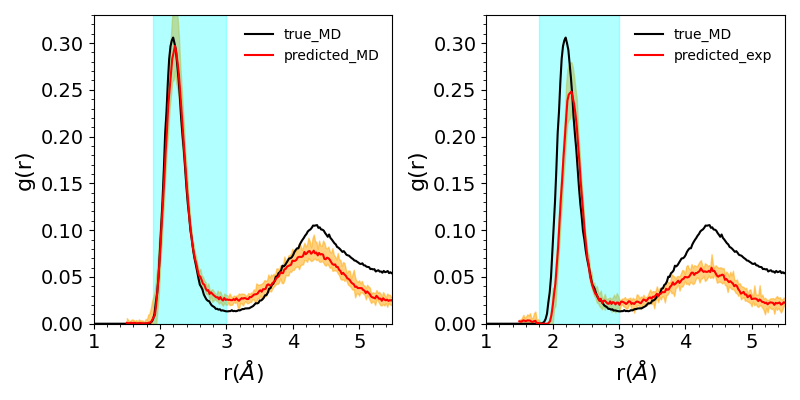

In [38]:
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].plot(rmesh_MD,gr_MD,'k',label='true_MD')
ax[0].fill_between(rmesh_new_MD,y_predict_list_min_MD,y_predict_list_max_MD,color='orange',alpha=0.5)
ax[0].axvspan(1.9, 3, alpha=0.3, color='cyan')
ax[0].plot(rmesh_new_MD,y_predict_list_mean_MD,'r',label='predicted_MD')
# ax[0].text(3,0.2,f"CN={np.round(CN_predict_mean_MD,2)}$\pm${np.round((CN_predict_max_MD-CN_predict_min_MD)/2,1)}",fontsize=14,color='r')
ax[0].set_xlabel("r($\AA$)",fontsize=16)
ax[0].set_ylabel("g(r)",fontsize=16)
ax[0].set_xlim(1,5.5)
ax[0].set_ylim(0,0.33)
ax[0].legend(frameon=False)
ax[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[0].tick_params(labelsize=14)

ax[1].fill_between(rmesh_new_exp,y_predict_list_min_exp,y_predict_list_max_exp,color='orange',alpha=0.5)

ax[1].plot(rmesh_MD,gr_MD,'k',label='true_MD')
ax[1].plot(rmesh_new_exp,y_predict_list_mean_exp,'r',label='predicted_exp')

ax[1].axvspan(1.8, 3, alpha=0.3, color='cyan')
# ax[1].text(3,0.2,f"CN={np.round(CN_predict_mean_exp,2)}$\pm${np.round((CN_predict_max_exp-CN_predict_min_exp)/2,2)}",fontsize=14,color='r')
ax[1].set_xlabel("r($\AA$)",fontsize=16)
ax[1].set_ylabel("g(r)",fontsize=16)
ax[1].set_xlim(1,5.5)
ax[1].set_ylim(0,0.33)
ax[1].legend(frameon=False)
ax[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[1].yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax[1].tick_params(labelsize=14)


plt.tight_layout()

In [39]:
report={
    'CN_MD':{'mean':np.round(CN_MD,1),'error':'-'},
    'CN_predict_MD':{'mean':np.round(CN_predict_MD,1),'error':np.round((CN_predict_max_MD-CN_predict_min_MD)/2,1)},
    'CN_predict_exp':{'mean':np.round(CN_predict_exp,1),'error':np.round((CN_predict_max_exp-CN_predict_min_exp)/2,1)},
    'radius_MD':{'mean':np.round(radius_MD,3),'error':'-'},
    'radius_predict_MD':{'mean':np.round(radius_predict_MD,2),'error':np.round((radius_predict_max_MD-radius_predict_min_MD)/2,2)},
    'radius_predict_exp':{'mean':np.round(radius_predict_exp,2),'error':np.round((radius_predict_max_exp-radius_predict_min_exp)/2,2)},
    'DW_MD':{'mean':np.round(DW_MD,3),'error':'-'},
    'DW_predict_MD':{'mean':np.round(DW_predict_MD,3),'error':np.round((DW_predict_max_MD-DW_predict_min_MD)/2,3)},
    'DW_predict_exp':{'mean':np.round(DW_predict_exp,3),'error':np.round((DW_predict_max_exp-DW_predict_min_exp)/2,3)},
    
}
pd.DataFrame(report)

,CN_MD,CN_predict_MD,CN_predict_exp,radius_MD,radius_predict_MD,radius_predict_exp,DW_MD,DW_predict_MD,DW_predict_exp
mean,7.9,8.2,6.7,2.313,2.35,2.38,0.019,0.022,0.018
error,-,0.8,0.6,-,0.02,0.01,-,0.001,0.001


In [40]:
radius_predict_max_MD

2.36228844712418

In [41]:
def coord_num(gr,rmesh,r1,r2):
    dr=rmesh[1]-rmesh[0]
    index_start=np.where(rmesh>=r1)[0][0]
    index_end=np.where(rmesh<=r2)[0][-1]
    const=4*np.pi*dr
    cn=0
    count=index_start
    for r in rmesh[index_start:index_end]:
        cn+=gr[count]*const*r**2
        count+=1

In [42]:
def radius(gr,rmesh,r1,r2):
    index_start=np.where(rmesh>=r1)[0][0]
    index_end=np.where(rmesh<=r2)[0][-1]
    dr=rmesh[1]-rmesh[0]
    radius=np.sum(gr[index_start:index_end+1]*rmesh[index_start:index_end+1]*dr)/np.sum(gr[index_start:index_end+1]*dr)
    return radius

def DW_factor(gr,rmesh,r1,r2):
    index_start=np.where(rmesh>=r1)[0][0]
    index_end=np.where(rmesh<=r2)[0][-1]
    dr=rmesh[1]-rmesh[0]
    DW_factor=np.sum(gr[index_start:index_end+1]*(rmesh[index_start:index_end+1]-np.mean(rmesh[index_start:index_end+1]))**2*dr)/np.sum(gr[index_start:index_end+1]*dr)
    return DW_factor


radius(y_predict_list_mean_exp,rmesh_new_exp,1.8,3)   
DW_factor(y_predict_list_mean_exp,rmesh_new_exp,1.8,3)

0.04139115580654837

# using EXAFS equation to reverse back k-signal
$\begin{align}
\chi(k)&=4\pi \sum^{r_{max}}_{r_{min}} \chi(k,r_i) g(r) r^2\Delta r\ \\
g(r)&=\frac{dN}{4\pi r^2 dr}\\
\chi(k,r)&=\frac{S_0^2}{kr^2}f(k)e^{-2r/\lambda(k)}sin(2kr+\delta(k,r))
\end{align}$
combine the two equations, we can get
$\begin{align}
\chi(k)=\frac{4\pi S_0^2f(k)}{k}\sum^{r_{max}}_{r_{min}}g(r_i)e^{-2r_i/\lambda(k)}sin(2kr_i+\delta(k))\Delta r_i \\
\end{align}$
in FEFF: <br>

![Alt text](image.png)

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# main_dir is the directory containing the feffxxx files.
main_dir = 'feff/'
UF4_std=exafs_recon.DataProcessor(main_dir)
UF4_std.print_pathes()

,file,sig2,amp ratio,deg,nlegs,r effective
0,feff0001.dat,0.0,100.000,1.0,2,2.2120
1,feff0002.dat,0.0,97.040,1.0,2,2.2365
2,feff0003.dat,0.0,94.880,1.0,2,2.2550
3,feff0004.dat,0.0,90.870,1.0,2,2.2906
4,feff0005.dat,0.0,90.290,1.0,2,2.2959
...,...,...,...,...,...,...
97,feff0110.dat,0.0,7.196,1.0,2,4.9028
98,feff0111.dat,0.0,5.448,2.0,3,4.9341
99,feff0112.dat,0.0,6.192,2.0,3,4.9429
100,feff0113.dat,0.0,3.377,2.0,3,4.9507


In [52]:
# process the data
pro = {}
for i in range(len(UF4_std.path_files["file"])):
    pro[UF4_std.path_files["file"][i]] = UF4_std.read_file(i)

    

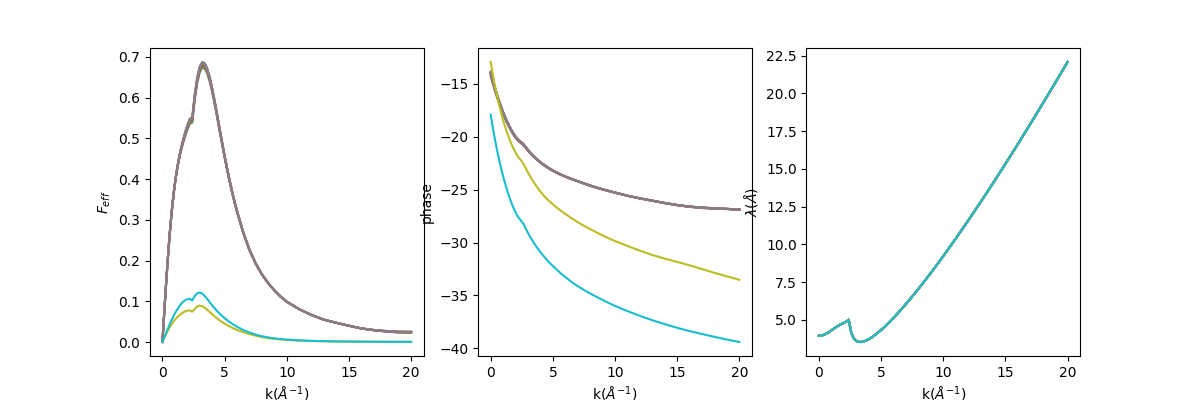

In [53]:

fig,ax=plt.subplots(1,3,figsize=(12,4))
for i in range(0,10):
    x,y=pro[UF4_std.path_files["file"][i]][['k','mag[feff]']].values.transpose()
    ax[0].plot(x,y)
    ax[0].set_xlabel('k($\AA^{-1}$)')
    ax[0].set_ylabel('$F_{eff}$')
    x,y=pro[UF4_std.path_files["file"][i]][['k','phase[feff]']].values.transpose()
    ax[1].plot(x,y)
    ax[1].set_xlabel('k($\AA^{-1}$)')
    ax[1].set_ylabel('phase')
    x,y=pro[UF4_std.path_files["file"][i]][['k','lambda']].values.transpose()
    ax[2].plot(x,y)
    ax[2].set_xlabel('k($\AA^{-1}$)')
    ax[2].set_ylabel('$\lambda(\AA)$')


In [54]:
%matplotlib widget

# Test 1: UF4 crystal
## Step 1 read structures from feff input file

In [48]:
from pymatgen.io.feff.inputs import Atoms
from pymatgen.core import Molecule

In [55]:
atoms_string=Atoms.atoms_string_from_file("feff/feff.inp")
# labels=np.array(labels)
# np.where(labels=='U0')
# len(labels)


lines = [line.split() for line in atoms_string.splitlines()[2:] if line != ''] #remember there is a bug
coords = []
symbols = []
for line in lines:
    if line:
        coords.append([float(val) for val in line[:3]])
        symbols.append(line[4])
cluster=Molecule(symbols, coords)

In [57]:
chi=np.loadtxt('feff/xmu.dat')
# chi1=np.loadtxt('feff/chip0001.dat',)
kmesh_MD_std=chi[:,2]
chi_MD_std=chi[:,5]

In [58]:
import scipy
pos=cluster.cart_coords
dis=scipy.spatial.distance.cdist([pos[0]],pos,metric='euclidean')[0]
r_UF4,gr_UF4_std=gr_util.gr_atom_from_dis_norho(dis,rmesh_new)


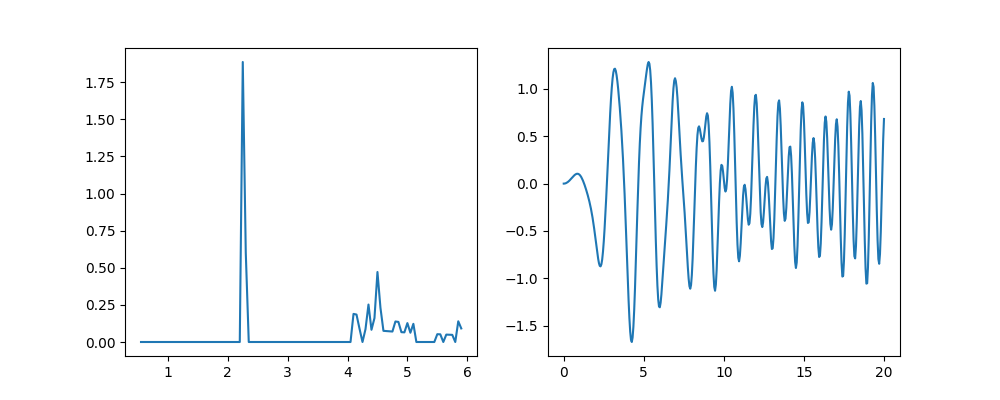

In [59]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].plot(r_UF4,gr_UF4_std)
ax[1].plot(kmesh_MD_std,kmesh_MD_std*kmesh_MD_std*chi_MD_std)

601

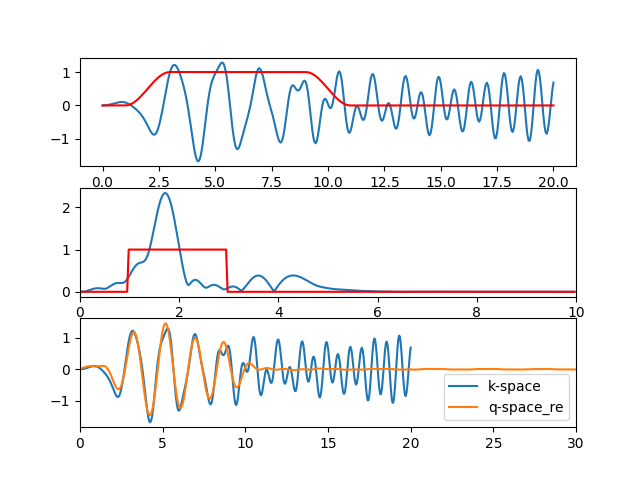

In [60]:
chi_UF4_test=chi_MD_std
k_UF4_test=kmesh_MD_std
UF4=Group(k=kmesh_MD_std,chi=chi_MD_std)
xftf(UF4.k,UF4.chi,group=UF4,kweight=2,kmin=2,kmax=10,dk=2,window='hanning')

fig,ax=plt.subplots(3,1)
ax[0].plot(UF4.k,UF4.k*UF4.k*UF4.chi)
ax[0].plot(UF4.k,np.round(UF4.kwin,3),'r')

xftr(UF4.r,UF4.chir,group=UF4,rmin=1,rmax=3,dr=0,window='hanning')

ax[1].plot(UF4.r,UF4.chir_mag)
ax[1].plot(UF4.r,np.round(UF4.rwin,3),'r')
ax[1].set_xlim(0,10)
ax[2].plot(UF4.k,UF4.k*UF4.k*UF4.chi,label='k-space')
ax[2].plot(UF4.q,UF4.chiq_re,label='q-space_re')


# ax[2].plot(UF4.q,UF4.q*UF4.q*UF4.chiq_im,label='q-space_im')
# ax[2].plot(UF4.q,UF4.q*UF4.q*UF4.chiq*0.2,label='q-space')


plt.legend()
ax[2].set_xlim(0,30)
len(UF4.q)

In [61]:
chi_top_all = []
rmesh_exafs=np.linspace(1.52,3.5,100)
kmesh_exafs=np.linspace(0.1,10,100)
kmesh_exafs,chi_exafs=UF4_std.gr2EXAFS(0,kmesh_exafs,rmesh_exafs,r_UF4,gr_UF4_std)
len(chi_exafs)

100

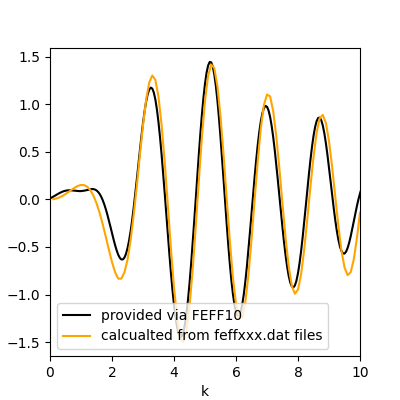

In [62]:
fig, ax = plt.subplots(1,1, figsize=(4,4))
plt.plot(UF4.q ,UF4.chiq_re, c='black', label = "provided via FEFF10")
plt.plot(kmesh_exafs,kmesh_exafs**2*chi_exafs, c='orange', label = "calcualted from feffxxx.dat files")
plt.xlim(0,10)
plt.xlabel('k')
plt.ylabel('chi(K)')

plt.legend()

# test 2 MD data

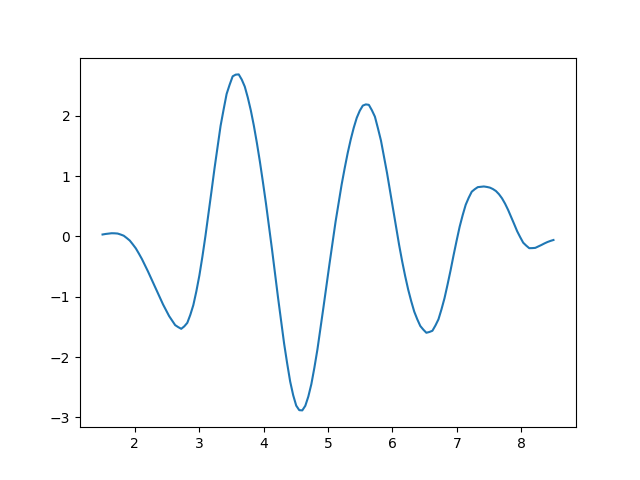

In [63]:
spectrum_MD=pd.read_csv("MD_data/output_ave_test_kx_MD.csv")
keys=list(spectrum_MD.keys())[1:]
gr_MD_table=pd.read_csv("MD_data/gr_output.csv")
gr_MD=gr_MD_table["UF4"]

# gr_MD=np.loadtxt('MD_data/gr_UF4.txt')
# gr_MD_F=np.loadtxt('MD_data/gr_UF4_F.txt')
# gr_MD_U=np.loadtxt('MD_data/gr_UF4_U.txt')
kmesh_MD=np.array(spectrum_MD['k'])
# rmesh_MD=np.loadtxt('MD_data/r_UF4.txt')
rmesh_MD=np.array(gr_MD_table['r'])
rmesh_new_MD=rmesh_MD
kmesh_new_MD=data_mod.kmesh_new
SO2=0.8

# kmesh_new=data_mod.kmesh_new
if data_mod.window_func=='hanning':
    # spectrum_test,w=data_mod.prepare_predict_data(np.array(spectrum_MD['UF4']),kmesh_MD)
    spectrum_test,w=data_mod.prepare_predict_data(chi_MD_recon,kmesh_recon)
else:
    spectrum_test=data_mod.prepare_predict_data(chi_MD_recon,kmesh_recon)

y_predict=model_list[0](spectrum_test)
# y_predict=y_predict.detach().numpy() 
if data_concate==True:
    gr_F,gr_U,gr_total_MD,rmesh_total_MD=data_mod.post_prediction(y_predict[0])
else:
    gr_total_MD,rmesh_total_MD=data_mod.post_prediction(y_predict[0])
plt.figure()
plt.plot(kmesh_new,spectrum_test[0][0])
# plt.plot(kmesh_new,w,'r')

In [60]:
data_mod.kmesh_new

array([1.5       , 1.54697987, 1.59395973, 1.6409396 , 1.68791946,
       1.73489933, 1.78187919, 1.82885906, 1.87583893, 1.92281879,
       1.96979866, 2.01677852, 2.06375839, 2.11073826, 2.15771812,
       2.20469799, 2.25167785, 2.29865772, 2.34563758, 2.39261745,
       2.43959732, 2.48657718, 2.53355705, 2.58053691, 2.62751678,
       2.67449664, 2.72147651, 2.76845638, 2.81543624, 2.86241611,
       2.90939597, 2.95637584, 3.0033557 , 3.05033557, 3.09731544,
       3.1442953 , 3.19127517, 3.23825503, 3.2852349 , 3.33221477,
       3.37919463, 3.4261745 , 3.47315436, 3.52013423, 3.56711409,
       3.61409396, 3.66107383, 3.70805369, 3.75503356, 3.80201342,
       3.84899329, 3.89597315, 3.94295302, 3.98993289, 4.03691275,
       4.08389262, 4.13087248, 4.17785235, 4.22483221, 4.27181208,
       4.31879195, 4.36577181, 4.41275168, 4.45973154, 4.50671141,
       4.55369128, 4.60067114, 4.64765101, 4.69463087, 4.74161074,
       4.7885906 , 4.83557047, 4.88255034, 4.9295302 , 4.97651

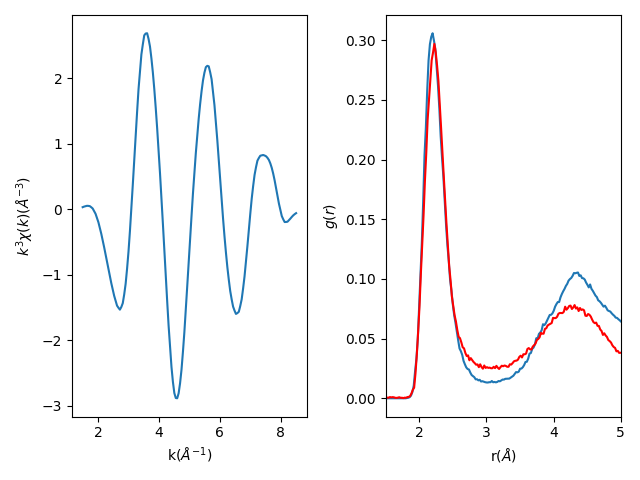

In [64]:
import larch
from larch import Group
from larch.xafs import xftf, xftr
# rmesh_new=rmesh[10:-15]
UF4_MD=Group(k=kmesh_new_MD,chi=np.array(spectrum_test[0][0]))

fig,ax=plt.subplots(1,2)

# for i in range(len(keys)):
ax[0].plot(UF4_MD.k,UF4_MD.chi)
ax[1].plot(rmesh_new_MD,gr_MD)
ax[1].plot(rmesh_total_MD,y_predict_list_mean_MD,'r')
ax[0].set_xlabel('k($\AA^{-1}$)')
ax[0].set_ylabel('$k^3\chi(k)$($\AA^{-3}$)')
ax[1].set_xlabel('r($\AA$)')
ax[1].set_ylabel('$g(r)$')
ax[1].set_xlim([1.5,5])
plt.tight_layout()

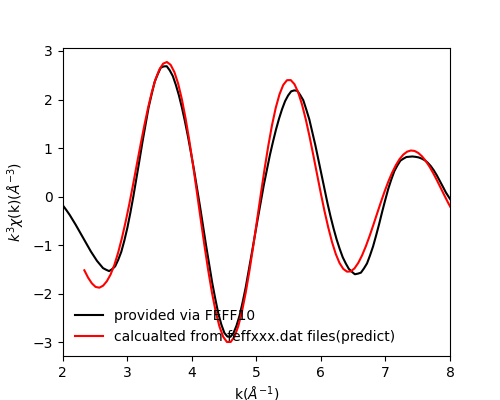

In [65]:
chi_top_all = []
chi_top_all_predict = []
chi_top_all_predict_f = []
rmesh_exafs=np.linspace(1.9,3,100)
kmesh_exafs=np.linspace(2,8,100)
kmesh_exafs_MD,chi_exafs_MD=UF4_std.gr2EXAFS(0,kmesh_exafs,rmesh_exafs,rmesh_new_MD,gr_MD)
kmesh_exafs_MD_P,chi_exafs_MD_P=UF4_std.gr2EXAFS(0,kmesh_exafs,rmesh_exafs,rmesh_total_MD,y_predict_list_mean_MD)
kmesh_exafs_MD_recon,chi_exafs_MD_recon=reconstruction(kmesh_exafs_MD,chi_exafs_MD,deltaE)
kmesh_exafs_MD_recon_P,chi_exafs_MD_recon_P=reconstruction(kmesh_exafs_MD_P,chi_exafs_MD_P,deltaE)
fig, ax = plt.subplots(1,1, figsize=(5,4))
plt.plot(UF4_MD.k ,UF4_MD.chi, c='black', label = "provided via FEFF10")
# plt.plot(kmesh_exafs,chi_exafs_MD*kmesh_exafs**3, c='blue', label = "calcualted from feffxxx.dat files")
plt.plot(kmesh_exafs_MD_recon_P,kmesh_exafs_MD_recon_P**3*chi_exafs_MD_recon_P, c='red', label = "calcualted from feffxxx.dat files(predict)")
# plt.plot(kmesh,kmesh*kmesh*sum_chi_all_predict_f, ':',c='blue', label = "calcualted from feffxxx.dat files(predict-f)")
plt.xlim(2,8)
plt.xlabel('k($\AA^{-1}$)')
plt.ylabel('$k^3\chi$(k)($\AA^{-3}$)')
plt.legend(frameon=False)